In [1]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Master file output
data = ascii.read("FishVBM_Therr_m20_2_52.out")
event_126 = data[data["EventID"] == 126]
print(event_126)

EventID SubRun Field ... ObsGroup_0_Fbase2_err ObsGroup_0_fs2_err LCOutput
------- ------ ----- ... --------------------- ------------------ --------
    126      2    52 ...     0.000948879943335  0.001267401531059        1


In [3]:
#LightCurve file
lc_data = ascii.read("FishVBM_Therr_m20_2_52_126.det.lc")

In [4]:
#Parameters file
def parse_prm_file(filepath):
    params = {}
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or "=" not in line:
                continue
            key, value = line.split("=", 1)
            params[key.strip()] = value.strip()
    return params

params = parse_prm_file("FVBM_m20.prm")

print(params)

sim_zero_time = float(params["SIMULATION_ZERO_TIME"])

{'RUN_NAME': 'FishVBM_Therr_m20', 'OUTPUT_DIR': '/work/fzohrabi/gulls_output/test/', 'FINAL_DIR': '/work/fzohrabi/gulls_output/test/', 'EXECUTABLE': 'gullsFish.x', 'OBSERVATORY_DIR': 'observatories/', 'OBSERVATORY_LIST': 'Roman_test_WZK.list', 'WEATHER_PROFILE_DIR': 'weather/', 'STARFIELD_DIR': 'starfields/', 'STARFIELD_LIST': 'gulls_surot2d_H2023.starfields', 'SOURCE_DIR': 'sources/', 'SOURCE_LIST': 'gulls_surot2d_H2023.sources', 'SOURCE_COLOURS': '0', 'LENS_DIR': 'lenses/', 'LENS_LIST': 'gulls_surot2d_H2023.lenses', 'LENS_COLOURS': '0', 'LENS_LIGHT': '1', 'PLANET_DIR': 'planet/m+20/', 'PLANET_ROOT': 'm+20.planets.', 'RATES_FILE': 'rates/src_gulls_surot2d_H2023.rates.v2', 'PRINCIPLE_OBSERVATORY': '0', 'OUTPUT_LC': '1', 'OUTPUT_IMAGES': '0', 'PRETTY_PICS': '0', 'PRETTY_PICS_DIMENSIONS': '128', 'OUTPUT_ONERR': '0', 'OUTPUT_ONDET': '1', 'OUTPUT_ONALL': '0', 'OUTPUT_FISH': '1', 'IDEAL_PHOTOMETRY': '-1', 'PARALLAX': '1', 'OBS_GROUPS': '(0,1,2)', 'NOBS': '3', 'NOBS_GROUPS': '1', 'OBS_GROUP_

        Notes
        -----
        The lightcurve columns are:
            [0] "Simulation_time"
            [1] "measured_relative_flux"
            [2] "measured_relative_flux_error"
            [3] "true_relative_flux"
            [4] "true_relative_flux_error"
            [5] "observatory_code"
            [6] "saturation_flag"
            [7] "best_single_lens_fit"
            [8] "parallax_shift_t"
            [9] "parallax_shift_u"
            [10] "BJD"
            [11] "source_x"
            [12] "source_y"
            [13] "lens1_x"
            [14] "lens1_y"
            [15] "lens2_x"
            [16] "lens2_y"

# Sanity Check

In [5]:
#from .out file
row = event_126[0]  
t0_ref = row["t0lens1"]
tE = row["tE_ref"]
rho = row["rho"]
u0_list = [row["u0lens1"]]
alpha = row["alpha"]
q = row["Planet_q"]
s = row["Planet_s"]

thetaE = row["thetaE"]

t0 = abs(t0_ref - sim_zero_time)

In [6]:
#manually from data available from the .lc file
mask = lc_data['col6'] == 0 #0 is the data we need

# Extract positions
source_x = lc_data['col12'][mask]
source_y = lc_data['col13'][mask]
lens1_x = lc_data['col14'][mask]
lens1_y = lc_data['col15'][mask]
lens2_x = lc_data['col16'][mask]
lens2_y = lc_data['col17'][mask] 
bjd = lc_data["col11"][mask]



#Extract flux
flux = lc_data["col4"][mask]
flux_error = lc_data["col5"][mask]
#s
s_lc = lens2_x[0] - lens1_x[0]

#distance to lens
dist = np.sqrt((source_x - lens1_x)**2 + (source_y - lens1_y)**2)

#t0: time of closest approach
idx_min = np.argmin(dist)
t0_lc = bjd[idx_min]

#tE
ds = np.sqrt((source_x[-1] - source_x[0])**2 + (source_y[-1] - source_y[0])**2)
dt = bjd[-1] - bjd[0]
v = ds / dt
tE_lc = 1.0 / v  # in days

#tau
tau_lc = (bjd - t0_lc) / tE_lc

#alpha
dx = source_x[-1] - source_x[0]
dy = source_y[-1] - source_y[0]
alpha_rad = np.arctan2(dy, dx)
alpha_deg = np.degrees(alpha_rad) % 360  
alpha_flipped = (alpha_deg + 180) % 360

#u0 parameter
x0 = source_x[len(source_x) // 2]
y0 = source_y[len(source_y) // 2]

numerator = (dx * y0 - dy * x0)
denominator = np.sqrt(dx**2 + dy**2)
u0_lc = numerator / denominator

print(rho)

0.01110032321202


In [7]:
print(f'Estimated s = {s_lc:.6},', f'GULLS output s={s}')
print(f'Estimated t0 = {t0_lc:.10},', f'GULLS output t0={t0}')
print(f'Estimated tE = {tE_lc:.6},', f'GULLS output tE={tE}')
print(f"Estimated alpha = {alpha_deg:.4f} degrees,", f'GULLS output alpha={alpha}')
print(f"Estimated u0 = {u0_lc:.6f},", f'GULLS output u0={u0_list}')

Estimated s = 1.34777, GULLS output s=1.347771197642
Estimated t0 = 2458261.929, GULLS output t0=2458206.0703329355
Estimated tE = 4.40305, GULLS output tE=4.403168559902
Estimated alpha = 274.3129 degrees, GULLS output alpha=274.3131637573
Estimated u0 = -0.086032, GULLS output u0=[np.float64(-0.08453353201416)]


# Plotting GULLS

Text(0, 0.5, 'Y')

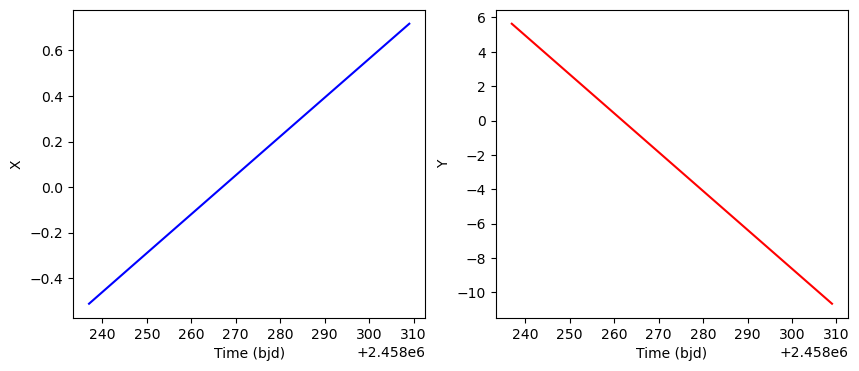

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(bjd, source_x, color='blue')
axs[0].set_title('')
axs[0].set_xlabel('Time (bjd)')
axs[0].set_ylabel('X')

axs[1].plot(bjd, source_y, color='red')
axs[1].set_title('')
axs[1].set_xlabel('Time (bjd)')
axs[1].set_ylabel('Y')

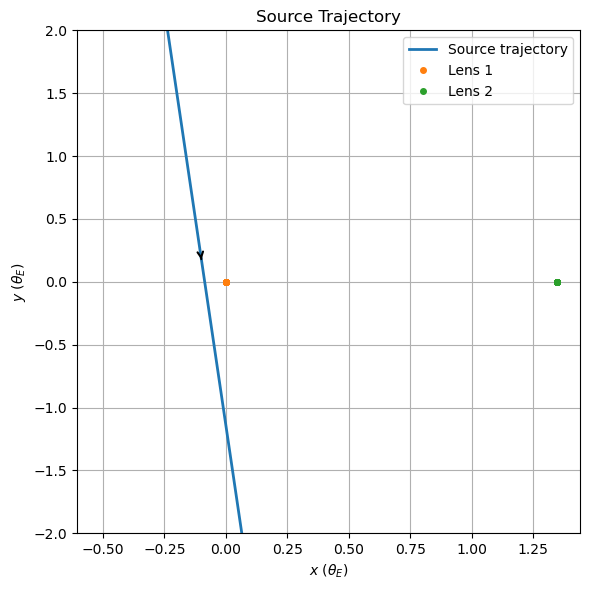

In [9]:
plt.figure(figsize=(6,6))

plt.plot(source_x, source_y, lw=2, label='Source trajectory')

# Annotate with an arrow from some point to a later point
start_idx = len(source_x) // 3
end_idx = start_idx + 20  # adjust the offset for the arrow length

plt.annotate(
    '', 
    xy=(source_x[end_idx], source_y[end_idx]), 
    xytext=(source_x[start_idx], source_y[start_idx]),
    arrowprops=dict(arrowstyle="->", lw=1.5 )
)

plt.plot(lens1_x, lens1_y, 'o', label="Lens 1", markersize=4)
plt.plot(lens2_x, lens2_y, 'o', label="Lens 2", markersize=4)

plt.ylim(-2,2)
plt.xlabel(r"$x$ ($\theta_E$)")
plt.ylabel(r"$y$ ($\theta_E$)")
plt.title("Source Trajectory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Comparing Model

In [10]:
from ML import TwoLens1S
model = TwoLens1S(t0=t0_lc, tE=tE, rho=rho, u0_list=u0_list, q=q, s=s, alpha=alpha, t_lc=bjd)
model2 = TwoLens1S(t0=t0_lc, tE=tE_lc, rho=rho, u0_list=[u0_lc], q=q, s=s_lc, alpha=alpha_flipped, t_lc=bjd)

In [11]:
print(alpha_flipped)

94.31289766803258


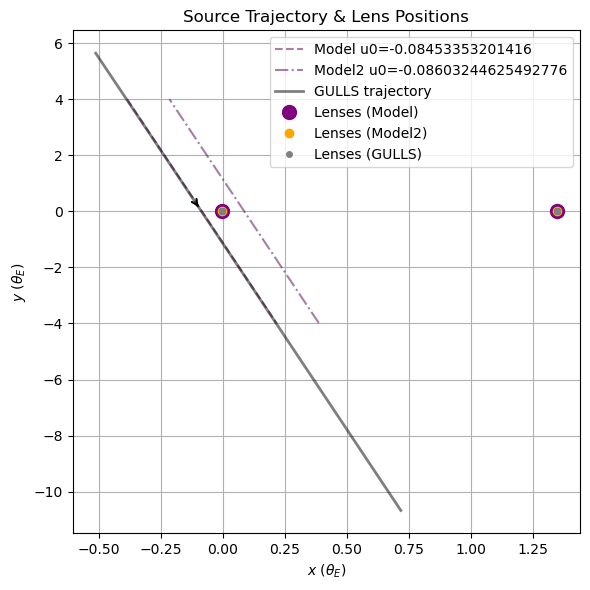

In [12]:
plt.figure(figsize=(6,6))


for system in model.systems:
    plt.plot(system['x_src'], system['y_src'], '--', color=system['color'], lw=1.5, label=f"Model u0={system['u0']}", alpha=0.5)


for system2 in model2.systems:
    plt.plot(system2['x_src'], system2['y_src'], '-.', color=system2['color'], lw=1.5, label=f"Model2 u0={system2['u0']}", alpha=0.5)


plt.plot(source_x, source_y, lw=2, label='GULLS trajectory', color='black', alpha=0.5)


start_idx = len(source_x) // 3
end_idx = start_idx + 20
plt.annotate(
    '', 
    xy=(source_x[end_idx], source_y[end_idx]),
    xytext=(source_x[start_idx], source_y[start_idx]),
    arrowprops=dict(arrowstyle="->", lw=1.5, color='black')
)


x1_model = -model.s * model.q / (1 + model.q)
x2_model = model.s / (1 + model.q)
plt.plot([x1_model, x2_model], [0, 0], 'o', color='purple', label='Lenses (Model)', markersize = 10)

x1_model2 = -model2.s * model2.q / (1 + model2.q)
x2_model2 = model2.s / (1 + model2.q)
plt.plot([x1_model2, x2_model2], [0, 0], 'o', color='orange', label='Lenses (Model2)')


plt.plot(lens1_x, lens1_y, 'o', color='grey', markersize=4, label="Lenses (GULLS)")
plt.plot(lens2_x, lens2_y, 'o', color='grey', markersize=4)

#plt.ylim(-3, 3)
plt.xlabel(r"$x$ ($\theta_E$)")
plt.ylabel(r"$y$ ($\theta_E$)")
plt.title("Source Trajectory & Lens Positions")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [13]:
model2.animate()

KeyboardInterrupt: 

In [14]:
model_tau = model.tau_lc
model_mag = model.systems[0]["mag"]

model2_tau = model2.tau_lc
model2_mag = model2.systems[0]["mag"]

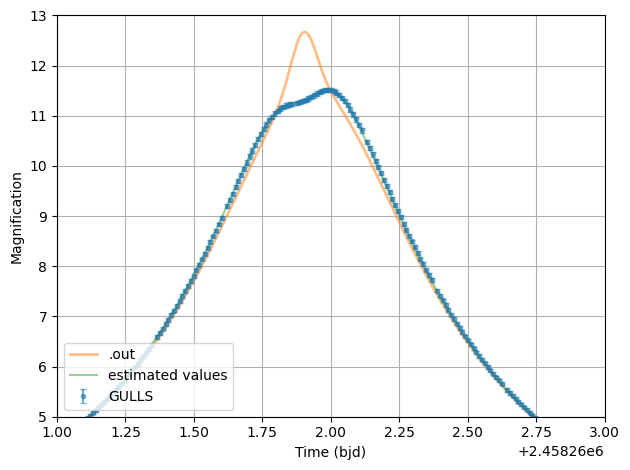

In [15]:
fs = 0.41432
magnification = (flux - (1 - fs)) / fs

sigma_mag = flux_error / fs

plt.errorbar(bjd, magnification, yerr=sigma_mag, fmt='.', label='GULLS', alpha=0.6, capsize=2)
plt.plot(bjd, model_mag, label=".out", lw=2, alpha=0.5)
plt.plot(bjd, model2_mag, label ="estimated values", alpha =.5)
plt.xlabel("Time (bjd)")
plt.ylabel("Magnification")

plt.ylim(5, 13)
plt.xlim(261+2.458e6, 263+2.458e6)

plt.legend(loc = 'lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Astrometry 

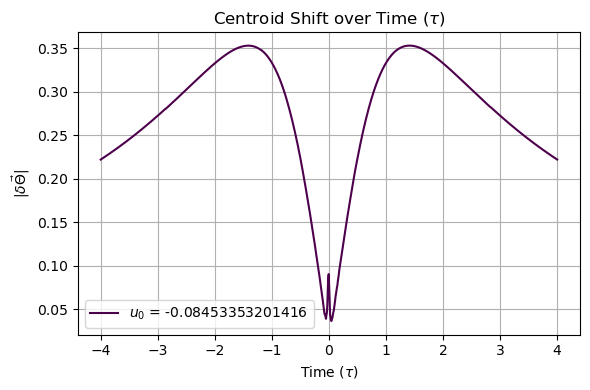

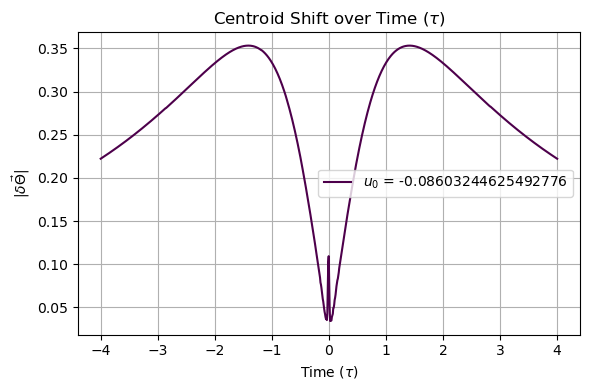

In [16]:
model.plot_centroid_shift()
model2.plot_centroid_shift()

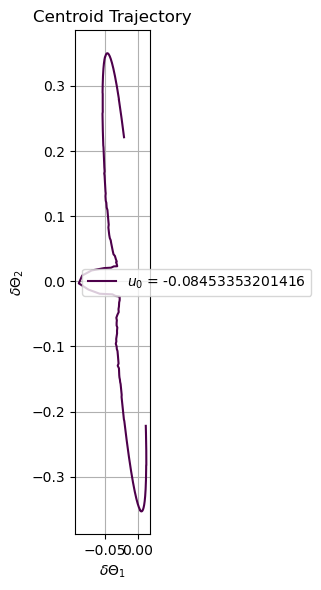

In [17]:
model.plot_centroid_trajectory()

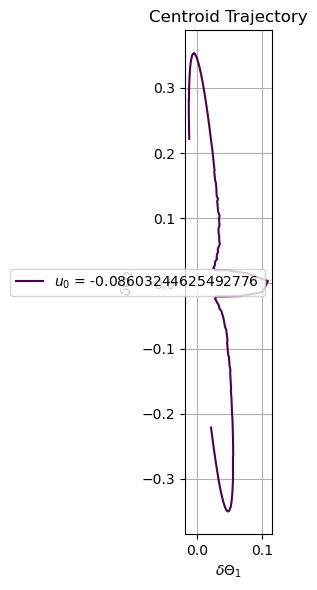

In [18]:
model2.plot_centroid_trajectory()

# Parallax Shift

In [ ]:
parallax_t = lc_data['col9'][mask]
parallax_u = lc_data['col10'][mask]

In [ ]:
source_x = - source_x
source_y = - source_y

In [ ]:
tau = (bjd - t0_lc) / tE_lc

alpha_rad = np.radians(alpha_flipped)

y1 = (-u0_lc * np.sin(alpha_rad) + tau * np.cos(alpha_rad))
y2 =  (u0_lc * np.cos(alpha_rad) + tau * np.sin(alpha_rad))

y1_parallax = y1 - parallax_t
y2_parallax = y2 - parallax_u

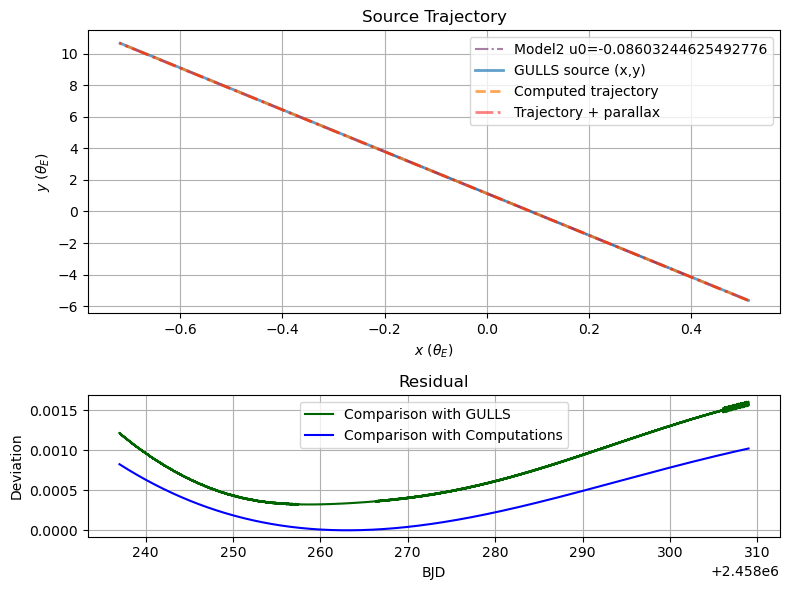

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=False, gridspec_kw={'height_ratios': [2, 1]})

#Trajectories
for system2 in model2.systems:
    axs[0].plot(system2['x_src'], system2['y_src'], '-.', color=system2['color'], lw=1.5, label=f"Model2 u0={system2['u0']}", alpha=0.5)
axs[0].plot(source_x, source_y, label='GULLS source (x,y)', lw=2, alpha=0.7)
axs[0].plot(y1, y2, '--', label='Computed trajectory', lw=2, alpha=0.7)
axs[0].plot(y1_parallax, y2_parallax, '-.', label='Trajectory + parallax', lw=2, alpha=0.5, color = 'red')

axs[0].set_xlabel(r"$x$ ($\theta_E$)")
axs[0].set_ylabel(r"$y$ ($\theta_E$)")
axs[0].set_title("Source Trajectory")
axs[0].legend()
axs[0].grid(True)

#Residuals
delta_x_parallax = y1_parallax - source_x
delta_y_parallax = y2_parallax - source_y
delta_total_parallax = np.sqrt(delta_x_parallax**2 + delta_y_parallax**2)

delta_x_p = y1_parallax - y1
delta_y_p = y2_parallax - y2
delta_total_p = np.sqrt(delta_x_p**2 + delta_y_p**2)

axs[1].plot(bjd, delta_total_parallax, color='darkgreen', lw=1.5, label="Comparison with GULLS")
axs[1].plot(bjd, delta_total_p, color='blue', lw=1.5, label = "Comparison with Computations")
axs[1].set_xlabel("BJD")
axs[1].set_ylabel("Deviation")
axs[1].set_title("Residual")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
normalized_parallax_t = parallax_t/thetaE
normalized_parallax_u = parallax_u/thetaE

In [ ]:
y1_parallax = y1 - normalized_parallax_t
y2_parallax = y2 - normalized_parallax_u

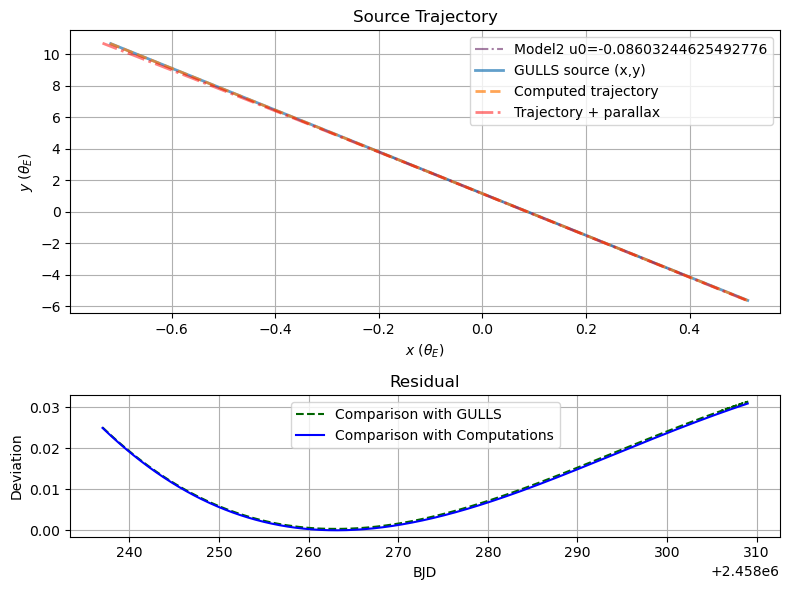

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=False, gridspec_kw={'height_ratios': [2, 1]})

#Trajectories
for system2 in model2.systems:
    axs[0].plot(system2['x_src'], system2['y_src'], '-.', color=system2['color'], lw=1.5, label=f"Model2 u0={system2['u0']}", alpha=0.5)
axs[0].plot(source_x, source_y, label='GULLS source (x,y)', lw=2, alpha=0.7)
axs[0].plot(y1, y2, '--', label='Computed trajectory', lw=2, alpha=0.7)
axs[0].plot(y1_parallax, y2_parallax, '-.', label='Trajectory + parallax', lw=2, alpha=0.5, color ='red')

axs[0].set_xlabel(r"$x$ ($\theta_E$)")
axs[0].set_ylabel(r"$y$ ($\theta_E$)")
axs[0].set_title("Source Trajectory")
axs[0].legend()
axs[0].grid(True)

#Residuals
delta_x_parallax = y1_parallax - source_x
delta_y_parallax = y2_parallax - source_y
delta_total_parallax = np.sqrt(delta_x_parallax**2 + delta_y_parallax**2)

delta_x_p = y1_parallax - y1
delta_y_p = y2_parallax - y2
delta_total_p = np.sqrt(delta_x_p**2 + delta_y_p**2)

axs[1].plot(bjd, delta_total_parallax, '--' , color='darkgreen', lw=1.5, label="Comparison with GULLS")
axs[1].plot(bjd, delta_total_p, color='blue', lw=1.5, label = "Comparison with Computations")
axs[1].set_xlabel("BJD")
axs[1].set_ylabel("Deviation")
axs[1].set_title("Residual")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()